In [1]:
#한글폰트 설치
#!sudo apt -qq -y install fonts-nanum

### 트랜스포머 번역기 만들기

In [7]:
#한글 폰트 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()


print("슝=3")

슝=3


### 내부 모듈 구현

- 입력 데이터 형태 : [batch_size x length]
- 출력 데이터 형태 : [batch_size x length x vocab_size]
- => 번역기능은 매 스텝마다 vocab_size 만큼의 클래스 개수 중 적당한 단ㄴ어를 선택하는 작업을 length 만큼 반복하는 것


- 단계별 데이터 형태의 변화
    - 입력 데이터 -> [batch_size x length]
    - source & target embedding -> [batch_size x length x d_emb]
    - positional encoding -> shape 변화 없음
    - multi-head attention 
        - split heads -> [batch_size x length x heads x (d_emb / n_heads)]
        - masking for masked attention
        - scaled dot product attention
        - combine heads -> [batch_size x length x d_emb]
    - residual connection
    - layer normalization
    - position-wise feed-forward network -> [batch_size x length x d_ff]
    - output linear layer -> [batch_size x length x vocab_size]
    

In [8]:
#라이브러리 임포트
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn # Attention 시각화를 위해 필요!

print(tf.__version__)

2.3.0


### 데이터다운로드

https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1

In [12]:
# $ mkdir -p ~/aiffel/transformer/data
# $ cd ~/aiffel/transformer/data
# $ wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
# $ gzip -d korean-english-park.train.tar.gz
# $ tar -xvf korean-english-park.train.tar

In [13]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

### 데이터 정제 및 토큰화

In [15]:
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)
    
    cleaned_corpus = set(zip(kor,eng))
    
    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path,eng_path)

In [21]:
cleaned_corpus

{('이번 폭발은 라자스탄주 성지인 아지메르에 있는 성인 묘지인 수피파 유적지 인근서 발생했다.',
  "The blast occurred outside Dargah Sharif, a Sufi monument in the state's pilgrimage town of Ajmer, during Iftar, the daily breaking of fast following Ramadan."),
 ('유엔 안보리는 국제사회의 평화와 안보를 총괄하는 기구로 안보리의 결의는 유엔의 모든 조직 가운데 유일하게 구속력을 갖고 있다.',
  'The council, which oversees global peace and security, is the only U.N. body whose decisions are all binding.'),
 ('그는 “경제제재는 이미 상당한 효가가 있음이 입증됐다”며 “이란이 핵프로그램을 중단하기 위해서는 보다 강력한 (경제)제재가 뒤따라야 한다”고 말했다.',
  'Up to the point where (Iran) stops its nuclear program," he said.'),
 ('워터스톤 서점의 웨인 윈스톤은 “코난 도일이 셜록 홈즈를 죽였다가 팬들과 출판사의 성원 속에 다시 살려낸 것처럼 해리포터도 되살아날 가능성이 있다”고 덫 붙였다.',
  '"Sir Arthur Conan Doyle famously killed off Sherlock Holmes, yet brought him back after years of demand from his fans and publishers," said Waterstone\'s Wayne Winstone. "Couldn\'t the same happen for Harry Potter?'),
 ('45일간의 점검기간 후 우주선이 임무를 시작할 예정이다.',
  'After a 45-day "checkout period," the craft will start its mission.')

In [26]:
def preprocess_sentence(sentence):
    
    sentence = sentence.lower().strip() #소문자 변환 및 양쪽 공백 제거
    
    sentence = re.sub(r"([?!,¿])",r"\1", sentence) #패턴의 특수문자 -> 특수문자 양족에 공백을 추가
    sentence = re.sub(r'[" "]+'," ", sentence) #공백 패턴 -> 스페이스 1개로 치환4
    sentence = re.sub(r"[^a-zA-Z0-9ㄱ-ㅎ|가-힣?.!,+¿]+", " ", sentence)  # a-zA-Z0-9ㄱ-ㅎ|가-힣?.!,+¿ 패턴을 제외한 모든 문자(공백문자까지도)를 스페이스 1개로 치환
    sentence = sentence.strip()    
    return sentence

print(preprocess_sentence("  I wan't Big Moneey$ #^#$    sentence."))   # 이 문장이 어떻게 필터링되는지 되는것을 통해 확인

i wan t big moneey sentence.


In [27]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    
    file = "./%s_corpus.txt" % lang
    model = "%s_spm" % lang

    with open(file, 'w') as f:
        for row in corpus: f.write(str(row) + '\n')

    import sentencepiece as spm
    spm.SentencePieceTrainer.Train(
        '--input=./%s --model_prefix=%s --vocab_size=%d'\
        % (file, model, vocab_size) + \
        '--pad_id==%d --bos_id=%d --eos_id=%d --unk_id=%d'\
        % (pad_id, bos_id, eos_id, unk_id)
    )

    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load('%s.model' % model)

    return tokenizer

In [28]:
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

In [29]:
for pair in cleaned_corpus:
    k, e = pair[:]

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

In [32]:
kor_corpus[:10]

['이번 폭발은 라자스탄주 성지인 아지메르에 있는 성인 묘지인 수피파 유적지 인근서 발생했다.',
 '유엔 안보리는 국제사회의 평화와 안보를 총괄하는 기구로 안보리의 결의는 유엔의 모든 조직 가운데 유일하게 구속력을 갖고 있다.',
 '그는 경제제재는 이미 상당한 효가가 있음이 입증됐다 며 이란이 핵프로그램을 중단하기 위해서는 보다 강력한 경제 제재가 뒤따라야 한다 고 말했다.',
 '워터스톤 서점의 웨인 윈스톤은 코난 도일이 셜록 홈즈를 죽였다가 팬들과 출판사의 성원 속에 다시 살려낸 것처럼 해리포터도 되살아날 가능성이 있다 고 덫 붙였다.',
 '45일간의 점검기간 후 우주선이 임무를 시작할 예정이다.',
 '그에 대한 재판은 2시간에 걸쳐 진행됐으며, 이에앞서 첸씨 측 변호인은 구속됐다.',
 '이스라엘은 레바논 남부의 교각과 도로에 야간 공습을 가하는 한편, 헤즈볼라 반군에 납치된 2명의 병사를 구출하기 위해 수색팀을 파견했다.',
 '샤라포바는 윌리엄스는 언제든 훌륭한 플레이를 펼칠 수 있는 선수 라며 그는 이미 여러 차례 그랜드 슬램을 정복했다 고 전했다.',
 '중국 국방성의 차오 강촨이 최고위 군 관계자와의 회담을 위해 5일 일정의 일본 방문을 시작할 예정이다.',
 '여행 계획에서 휴대전화에 대해 미리 걱정하지 마라.']

In [33]:
eng_corpus[:10]

['the blast occurred outside dargah sharif, a sufi monument in the state s pilgrimage town of ajmer, during iftar, the daily breaking of fast following ramadan.',
 'the council, which oversees global peace and security, is the only u.n. body whose decisions are all binding.',
 'up to the point where iran stops its nuclear program, he said.',
 'sir arthur conan doyle famously killed off sherlock holmes, yet brought him back after years of demand from his fans and publishers, said waterstone s wayne winstone. couldn t the same happen for harry potter?',
 'after a 45 day checkout period, the craft will start its mission.',
 'li said he was outraged by the sentence.',
 'israel has launched night air strikes on bridges and roads in southern lebanon, as the search goes on for two soldiers seized by hezbollah militants.',
 'that s what has won her so many grand slams.',
 'communist chinese defense minister cao gangchuan is to begin a five day visit to japan for talks with top military leaders

In [34]:
ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

True

In [35]:
from tqdm import tqdm_notebook    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm_notebook(range(len(kor_corpus))):
    # [[YOUR CODE]]
    src_tokens = ko_tokenizer.encode_as_ids(kor_corpus[idx])
    tgt_tokens = en_tokenizer.encode_as_ids(eng_corpus[idx])

    if (len(src_tokens) > 50): continue
    if (len(tgt_tokens) > 50): continue
    
    src_corpus.append(src_tokens)
    tgt_corpus.append(tgt_tokens)

/home/aiffel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [36]:
# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

In [37]:
enc_train.shape, dec_train.shape

((74394, 50), (74394, 50))

### 모델설계

In [58]:
# positional encoding 구현

def positional_encoding(pos,d_model):
    def cal_angle(position, i):
        return position / np.power(10000,int(i) / d_model)
    
    def get_posi_angel_vec(position):
        return[cal_angle(position, i) for i in range(d_model)]
    
    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    
    return sinusoid_table

print('done')

done


In [59]:
# multi-head attention 구현
# split_heads() => Embedding 된 입력을 Head 수로 분할하는 함수
# scaled_dot_product_attention() => Attentiion 값을 구하는 함수
# comine_heads() => 연산이 종료되고 분할된 Head를 다시 하나로 결합하는 함수
# MultiHeadAttention 클래스 정의로 일괄 포함

# masking 구현은 모델 생성 이후에 구현

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_moel, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model) # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)
        
    def scaled_dot_product_attention(self,Q,K,V,mask):
        d_k = tf.cast(K.shape[-1],tf.float32)
        
        '''
        Scaled QK 값 구하기
        '''
        QK = tf.matmul(Q, K, transpose_b = True)
        
    
        scaled_qk = QK / tf.math.sqrt(d_k)
        
        if maks is not None:
            scaled_qk += (mask *-1e9)
            
        '''
        1.Attention Weights 값 구하기 -> attentions
        2.Attention 값을 V에 곱하기 -> out
        '''
        attention = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions,V)
        
        
        return out, attentions
    
    def split_heads(self, x):
        '''
        Embedding을 Head의 수로 분할하는 함수
        x:[batch x length x emb]
        return:[batch x length x emb]
        '''
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0,2,1,3])
        
        return split_x
    
    def combine_heads(self, x):
        '''
        Embedding을 Head의 수로 합치는 함수
        x:[batch x length x emb]
        return:[batch x length x emb]
        '''
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))
        
        return cobined_x
    
    
    def call(self,Q,K,V,mask):
        
        
        #step 1 : Linear_in(Q,K,V) -> WQ,WK,WV
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        #step 2 : Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        #step 3 : Scaled Dot Product Attention (WQ_spli, WK_split, WV_split)
        out, attention_weights = self.scaled_dot_product_attention(WQ_splits, WK_splits, WV_splits, mask)

        #step 4 : Combined Heads(out) -> out
        out = self.combine_heads(out)
        
        #step 5 : Linear_out(out) -> out
        out = self.linear(out)
        
        
        return out, attention_weights
    
print('done')


done


In [60]:
# Position-wise Feed-Forward Network 구현

class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__ (self, d_model, d_ff):
        
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layer.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layer.Dense(d_model)
        
        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        slef.fc2 = tf.keras.layers.Dense(d_model)
        
    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
        
        return out
    
print('done')

done


### Encoder 레이어 구현


In [61]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__ (self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        
        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model,d_ff)
        
        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self,x,mask):
        
        '''
        Multi-Head Attention
        '''
        
        residual = x
        out = self.norm_1(x)
        out,enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out,enc_attn
    
print('done')

done


###  Decoder 레이어 구현하기

In [62]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, causality_mask)
        out = self.do(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, padding_mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

### Encoder & Decoder 클래스 정의

In [63]:
class Encoder(tf.keras.Model):
    def __init__(self,
                n_layers,
                d_model,
                n_heads,
                d_ff,
                dropout):
        super(Encoder,self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model,n_heads,d_ff,dropout)
                          for _ in range(n_layers)]
        
        self.do = tf.keras.layer.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
        
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, maks)
            enc_attns.append(enc_attn)
        return out, enc_attns
print('done')

done


In [64]:
class Decoder(tf.keras.Model):
    def __init__(self,
                n_layers,
                d_model,
                n_heads,
                d_ff,
                dropout):
        super(Decoder,self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout)
                          for _ in range(n_layers)]
        
        def call(self,x,enc_out,causality_mask, padding_mask):
            out = x
            
            dec_attns = list()
            dec_enc_attns = list()
            for i in range(self.n_layers):
                out, dec_attn, dec_enc_attn = \
                self.dec_layers[i](out, enc_out, causality_mask, padding_mask)
                
                dec_attns.append(dec_attn)
                dec_enc_attns.append(dec_enc_attn)
                
            return out, dec_attns, dec_enc,attns
print('done')

done


### Transformer 완성하기
- `shared` 변수를 매개변수로 받아 `True`일 경우 **Decoder Embedding과 출력층 Linear의 Weight를 공유** 할 수 있게 할 것

    - Weight가 공유 될 경우 Embeddidng 값에 `sqrt(d_moel)`을 곱해줘야 함
    
    - `tf.keras.layers.Layer.set_weights()`
    
- 앞서 정의한 `positional_encoding`의 반환값 형태는 `[Length x d_model]` 이므로

- 이를 더해줄 Embedding 값 형태를 연산이 가능하도록 수정할 것

    - `[ Batch X Length X d_model]` 은 연산이 불가능
    - `tf.expand_dims()`, `np.newaxis` 참고
    

In [65]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()

        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out


    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

### Masking
- `generate_causality_mask()` 변형

In [66]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

print('done')

done


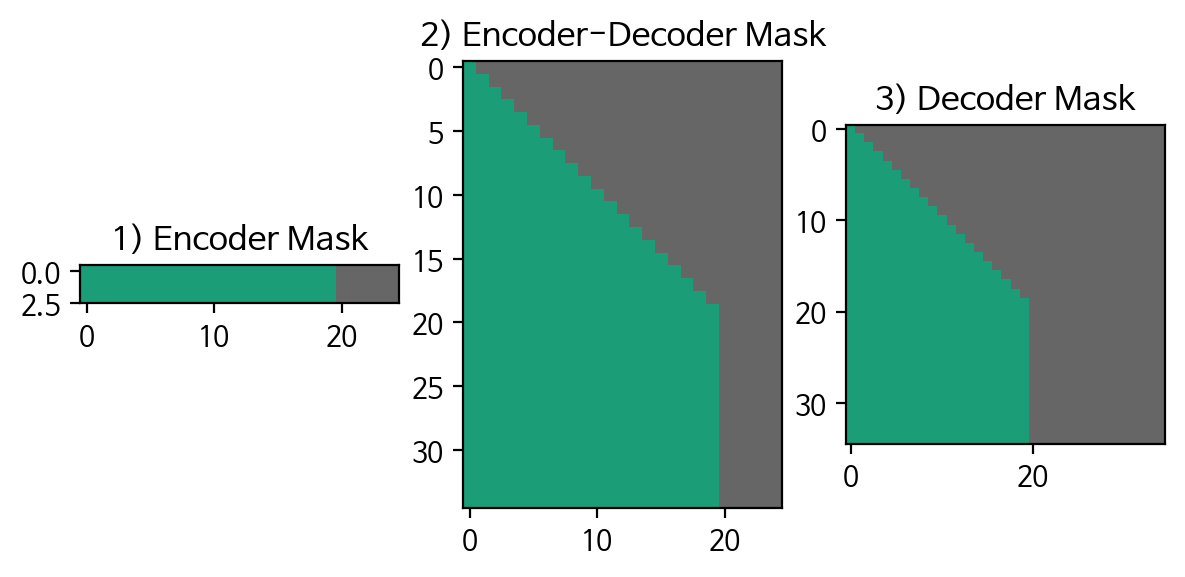

In [67]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

### LearningRateSchedule 

In [68]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self,d_model,warmup_steps=4000):
        super(LearningRateScheduler,self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        
    def __call__(self,step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return(self.d_model ** -0.5) * tf.math.minimum(arg1,arg2)
    
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                    beta_1=0.9,
                                    beta_2=0.98,
                                    epsilon=1e-9)
print('done')

done


In [69]:
N_LAYERS= 2
D_MODEL = 512
N_HEADS = 8
D_FF    = 2048
DROPOUT = 0.3

In [70]:
transformer = Transformer(
    n_layers=N_LAYERS,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    d_ff=D_FF,
    src_vocab_size=SRC_VOCAB_SIZE,
    tgt_vocab_size=TGT_VOCAB_SIZE,
    pos_len=200,
    dropout=DROPOUT,
    shared_fc=True,
    shared_emb=True)

d_model = 512

NameError: name 'get_posi_angle_vec' is not defined

In [71]:
learning_rate = LearningRateScheduler(512)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

In [72]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [73]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

In [74]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [75]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [76]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

### 학습

In [77]:
from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 20

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

In [78]:
for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

/home/aiffel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


NameError: name 'transformer' is not defined

In [79]:
for example in examples:
    translate(example, transformer, ko_tokenizer, en_tokenizer,plot_attention= True)

NameError: name 'transformer' is not defined

### 한영 번역기 만들기

#### 평가문항	
1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다.
    - 데이터 정제, SentencePiece를 활용한 토큰화 및 데이터셋 구축의 과정이 지시대로 진행되었다.
2. Transformer 번역기 모델이 정상적으로 구동된다.
    - Transformer 모델의 학습과 추론 과정이 정상적으로 진행되어, 한-영 번역기능이 정상 동작한다.
3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.
    - 제시된 문장에 대한 그럴듯한 영어 번역문이 생성되며, 시각화된 Attention Map으로 결과를 뒷받침한다.

### 1.데이터 다운로드
- jungyeul/korean-parallel-corpora
- https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1

### 2.데이터 정제 및 토큰화
- set 데이터형을 활용하여 중복된 데이터 제거
- 데이터의 병렬 쌍이 흐트러지지 않게 주의할 것
- 중복을 제거한 데이터를 cleaned_corpus에 저장


In [35]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

from konlpy.tag import Mecab
import pandas as pd

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)
    
    
    raw_df = pd.DataFrame( {
    'kor' : kor,
    'eng' : eng
    })
    
    #데이터중복 제거
    cleaned_corpus = raw_df.drop_duplicates()
    
    return cleaned_corpus


In [36]:
cleaned_corpus = clean_corpus(kor_path, eng_path)

In [38]:
cleaned_corpus.head()

,kor,eng
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee..."
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...


In [39]:
cleaned_corpus.info

<bound method DataFrame.info of                                                      kor  \
0                   개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"   
1      모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...   
2                             그러나 이것은 또한 책상도 필요로 하지 않는다.   
3      79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...   
4      정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...   
...                                                  ...   
94118  “우리는 3월 8일 김승연 회장과 그의 아들이 보복폭행에 가담한 혐의를 찾기 위해 ...   
94119   월요일 술집 종업원 6명은 김회장과 아들에게 폭행을 당했음을 진술했다고 경찰은 말했다.   
94120                       그러나 불충분한 증거 확보로 수사에 어려움이 있다.   
94121                  김회장과 그의 아들은 보복폭행 혐의를 강력히 부인하고 있다.   
94122  경찰은 김회장의 집무실에서 추가 증거를 찾은 이후 가능한 한 오늘 김회장과 아들을 ...   

                                                     eng  
0      Much of personal computing is about "can you t...  
1      so a mention a few weeks ago about a rechargea...  
2      Like all optical mice, But it also doesn't nee...  
3      uses

#### 데이터 정제 함수 선언
- 모든 입력을 소문자로 변환
- 알파벳, 문장부호, 한글만 남기고 모두 제거
- 문장부호 양옆에 공백을 추가
- 문장 앞뒤의 불필요한 공백을 제거


In [41]:
def preprocess_sentence(sentence):
    
    sentence = sentence.strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) # ?.!, 가 나오면 앞에 한칸 띄어주기
    sentence = re.sub(r'[" "]+', " ", sentence) # 띄어쓰기 여러개가 되어 있으면 하나로 줄이기
    
    sentence = re.sub(r"[^a-z?.!,]+", " ", sentence)
    #strip() -> 문자열에서 특정 문자 제거
    sentence = re.sub(r"[^[ㄱ-ㅎ|가-힣?.!,]+"," ", sentence).strip() #한글 ? . !, 문자 부호가 아니면 빈칸으로 대체
    sentence = sentence.replace(sentence, sentence.lower())
    
    sentence = mecab.morphs(sentence)    # mecab() 이용해 문장 분절
    
    return sentence

#### 한글 말뭉치 와 영문 말뭉치 분리, 정제
- 토큰화에는 Sentencepiece를 활용
- 단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 할 것 (기본 : 20,000)
- 학습 후 저장된 model 파일을 SentencePiecePrrocessor() 클래스에 Load() 한 후 반환
- 특수 토큰의 인덱스를 아래와 동일하게 지정
    - <PAD> : 0 / <BOS> : 1 / <EOS> : 2 / <UNK> :3


In [40]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',num_words=10000)
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tokenizer
    

SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k, e = pair.split("\t")

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

ValueError: not enough values to unpack (expected 2, got 1)

#### 토크나이저 활용하여 토큰의 길이가 50이하인 데이터 선별
- src_corpus -> enc_train
- tgt_corpus -> dec_train


In [ ]:
from tqdm import tqdm_notebook    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm_notebook(range(len(kor_corpus))):
    # [[YOUR CODE]]

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

### 3. 모델 설계

### 4.훈련하기
- 2 Layer를 가지는 Transformer 선언

In [ ]:
transformer = # [[YOUR CODE]]

- 논문과 동일한 Learning Rate Scheduler를 선언
- Adam Optimizer를 선언

In [ ]:
learning_rate = # [[YOUR CODE]]
optimizer = # [[YOUR CODE]]

- Loss 함수 정의
    - seq2seq모델에서 사용했던 Loss와 유사하되,
    - Maskiing 되지 않은 입력의 개수로 Scaling 하는 과정 추가

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

- train_step 함수 정의
    - 입력 데이터에 알맞은 Mask 생성

In [ ]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    # [[YOUR CODE]]
    
    return loss, enc_attns, dec_attns, dec_enc_attns

- 학습 진행
    - 매 Epoch 마다 제시된 예문에 대한 번역 생성 -> 자연스러운 번역이 생성되면 그때의 하이퍼 파라미터와 생성된 번역을 제출

In [ ]:
# 학습

from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 20

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)


예문)
1. 오바마는 대통령이다.
2. 시민들은 도시 속에 산다.
3. 커피는 필요 없다.
4. 일곱 명의 사망자가 발생했다.

결과)
Translations
1. obama is the president elect .
2. they are in the city .
3. they don t need to be a lot of drink .
4. seven other people have been killed in the attacks .

Hyperparameters
- n_layers: 2
- d_model: 512
- n_heads: 8
- d_ff: 2048
- dropout: 0.3

Training Parameters
- Warmup Steps: 4000
- Batch Size: 64
- Epoch At: 5


### 번역결과 시각화

In [4]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [5]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [6]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

### 회고
- 트랜스포머의 각 모듈을 구성해보고 조합하면서 막연했던 내부 구조에 대한 이해가 조금 생긴것 같다
- 실제 번역기 기능 구현에 있어서는 전처리 과정에서부터 아직 어떻게 접근해야할지 잘 모르겠다
- 무작정 코드를 따라 쳐보기도하고, 코드에 담긴 파라미터에 대한 이해도 해보았지만, 프로젝트 형태로 진행하려고 하면 항상 작업의 흐름을 어떻게 이루어야 할지 막막한것 같다.
